In [1]:
import allantools
import allan_variance
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame, read_csv
from scipy.optimize import nnls
from collections import OrderedDict
import pandas as pd
import csv
import lowpass
from scipy.signal import butter, lfilter, freqz
import pywt
from statsmodels.robust import mad

In [2]:
#%pylab inline
#pylab.rcParams['figure.figsize'] = (30, 20)

# Read data from csv

In [3]:
with open('imu_linear.csv','rb') as csvinput:
    reader = csv.reader(csvinput)
    for row in reader:
        try:
            num_cols = len(reader.next())
        except:
            pass

In [4]:
# This variable is for the complete header of the file
            # time                   # magnitude
names = ['linear_acceleration.x_x','linear_acceleration.x_y', # x variable
         'linear_acceleration.y_x','linear_acceleration.y_y', # y variable
         'linear_acceleration.z_x','linear_acceleration.z_y'] # z variable
# columns that I will work with now
sensor_raw = pd.read_csv('imu_linear.csv', header = None,names = names)


# Working with x magnitude

Read data from csv

In [5]:
useful_names = ['linear_acceleration.x_x','linear_acceleration.x_y']
x_data = pd.read_csv('imu_linear.csv', header = None,names = names, usecols = useful_names)

Read time and data separately, convert to numpy array

In [6]:
x_time = pd.read_csv('imu_linear.csv', header = None,names = names, usecols = ['linear_acceleration.x_x'])

x_time_array = x_time.values
x_time_array = np.delete(x_time_array,0)

#x_time_array.delete('linear_acceleration.x_x')
t = []
for i in x_time_array:
    t.append(float(i))

In [7]:
x_data = pd.read_csv('imu_linear.csv', header = None,names = names, usecols = ['linear_acceleration.x_y'])

x_data_array = x_data.values
x_data_array = np.delete(x_data_array,0)

#x_time_array.delete('linear_acceleration.x_x')
x = []
for i in x_data_array:
    x.append(float(i))

Plot to check everything is OK

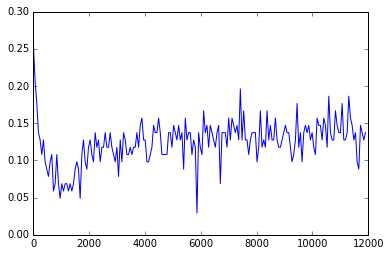

In [8]:
plt.plot(t,x)

## Computing Allan Variance

Measurement noise can be modelled by using the Allan deviation (ADEV), expressed as $\sigma_y(\tau)$, which is the square root of the Allan Variance (AVAR). 
The Allan variance measures the frequency stability of a measurement, which is thus expressed as $\sigma_y^2(\tau)$.

When $\tau$ is small, the Allan variance function is decreasing, which is the characteristic of a measurement noise. At larger $\tau$, the slope decreases, indicating the presence of a bias noise.
The results from this method are related to five basic noise terms appropriate for inertial sensor data. These are quantization noise, angle random walk, bias instability, rate random walk,  and rate ramp.

In [9]:
allan_x = allantools.Dataset(data=x)
# Evaluate the passed function with the supplied data.
x_mdev = allan_x.compute("mdev")
x_mdev

{'stat': array([ 0.0345384 ,  0.012306  ,  0.0047137 ,  0.00178974,  0.00080626,
         0.000282  ,  0.00022469]),
 'stat_err': array([  2.45453747e-03,   8.81250659e-04,   3.42870921e-04,
          1.34525162e-04,   6.51826559e-05,   2.75207752e-05,
          7.48981822e-05]),
 'stat_n': array([ 198.,  195.,  189.,  177.,  153.,  105.,    9.]),
 'taus': array([  1.,   2.,   4.,   8.,  16.,  32.,  64.])}

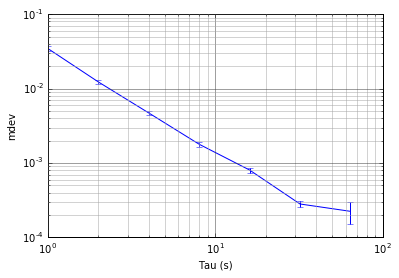

In [10]:
allan_x_plot = allantools.Plot()
allan_x_plot.plot(allan_x, errorbars=True, grid=True)
# You can override defaults before "show" if needed
allan_x_plot.ax.set_xlabel("Tau (s)")
allan_x_plot.show()

## Noise identification with Allan tools

- Quantization noise: Quantization  noise  is  one  of  the  types  of  error  introduced  into  an  analog  signal  that  results  from  encoding  it  in  digital form.  

- White Noise/Random Walk appears on the Allan variance plot as a slope with gradient   –0.5. The random walk measurement for this noise (ARW for a rate-gyrosco
pe, VRW for an accelerometer) is obtained by fitting a straight line through the slope and reading its value at tau= 1. ARW in gyroscope is a measure for gyro noise and is given in units of dps/rt(Hz).

- Flicker Frequency noise or Bias Instability: This is a
low frequency bias fluctuation in the measured rate data. The
origin of this noise is the electronics, or other components
susceptible to random flickering. It appears on the plot as a flat region around the minimum. The numerical value is the minimum value on the Allan deviation plot. For a gyroscope, the bias stability measures how the bias of the gyroscope changes over a specified period of time at constant temperature.  This is typically presented in units of dps/sec or dps/hr.

-  Rate Random Walk: The high frequency noise term that have correlation time
much shorter than the sample time can contribute to the gyro
angle (or accelerometer velocity) random walk. These noise
terms are all characterized by a white-noise spectrum on the
gyro (or accelerometer) output rate.

- Drift Rate Ramp: This error belongs to deterministic errors. It is slow
monotonic change of output over a long time period

In [11]:
x_tau  = x_mdev['taus']
x_avar = x_mdev['stat']
xparams, av_pred = allan_variance.params_from_avar(x_tau,x_avar,output_type='dict')
xparams

OrderedDict([('quantization', 0.097514110547606087),
             ('white', 0.097486233921995916),
             ('flicker', 0.0),
             ('walk', 0.0),
             ('ramp', 0.00017194493172835906)])

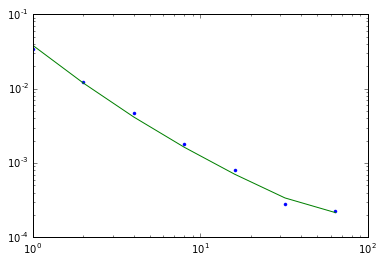

In [12]:
plt.loglog(x_tau, x_avar, '.')
plt.loglog(x_tau, av_pred)

In [13]:
bias_instability  = x_mdev['stat'][3]
bias_instability 

0.0017897408706259166

In [14]:
bias_instability_err  = x_mdev['stat_err'][3]
bias_instability_err

0.0001345251616560295

 ## Filtering

### Low-pass filter

In [15]:
# Filter requirements.
order = 2
fs = 1000/(t[1]-t[0])       # sample rate, Hz
print fs
cutoff = fs/10 # desired cutoff frequency of the filter, Hz

16.693544361


In [16]:
# Get the filter coefficients so we can check its frequency response.
b, a = lowpass.butter_lowpass(cutoff, fs, order)
b, a

(array([ 0.06745527,  0.13491055,  0.06745527]),
 array([ 1.       , -1.1429805,  0.4128016]))

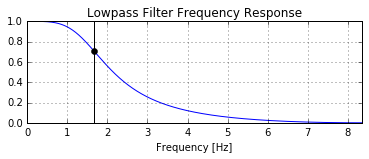

In [17]:
# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

In [18]:
# Filter the data, and plot both the original and filtered signals.
x_lpf = lowpass.butter_lowpass_filter(x, cutoff, fs, order)

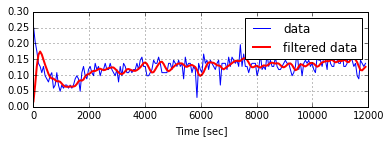

In [19]:
plt.subplot(2, 1, 2)
plt.plot(t, x, 'b-', label='data')
plt.plot(t, x_lpf, 'r-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.figure(figsize=(100, 50), dpi= 80, facecolor='w', edgecolor='k')
fig_size = [60,30]
plt.rcParams['figure.figsize'] = fig_size
plt.gcf().set_size_inches(*fig_size)
plt.show()

### Moving average filter

Calculating a moving average involves creating a new series where the values are comprised of the average of raw observations in the original time series.

A moving average requires that you specify a window size called the window width. This defines the number of raw observations used to calculate the moving average value.

The “moving” part in the moving average refers to the fact that the window defined by the window width is slid along the time series to calculate the average values in the new series.

Types:

- Centered Moving Average: The value at time (t) is calculated as the average of raw observations at, before, and after time (t).
- Trailing Moving Average: The value at time (t) is calculated as the average of the raw observations at and before the time (t).

In [20]:
# Select window size for average filter of 17
# which is the number of measurements read in 1s
window_size = 17
x_avg = np.zeros(len(x))
avg_mask = np.ones(window_size)/window_size
x_avg = np.convolve(x, avg_mask, 'same')

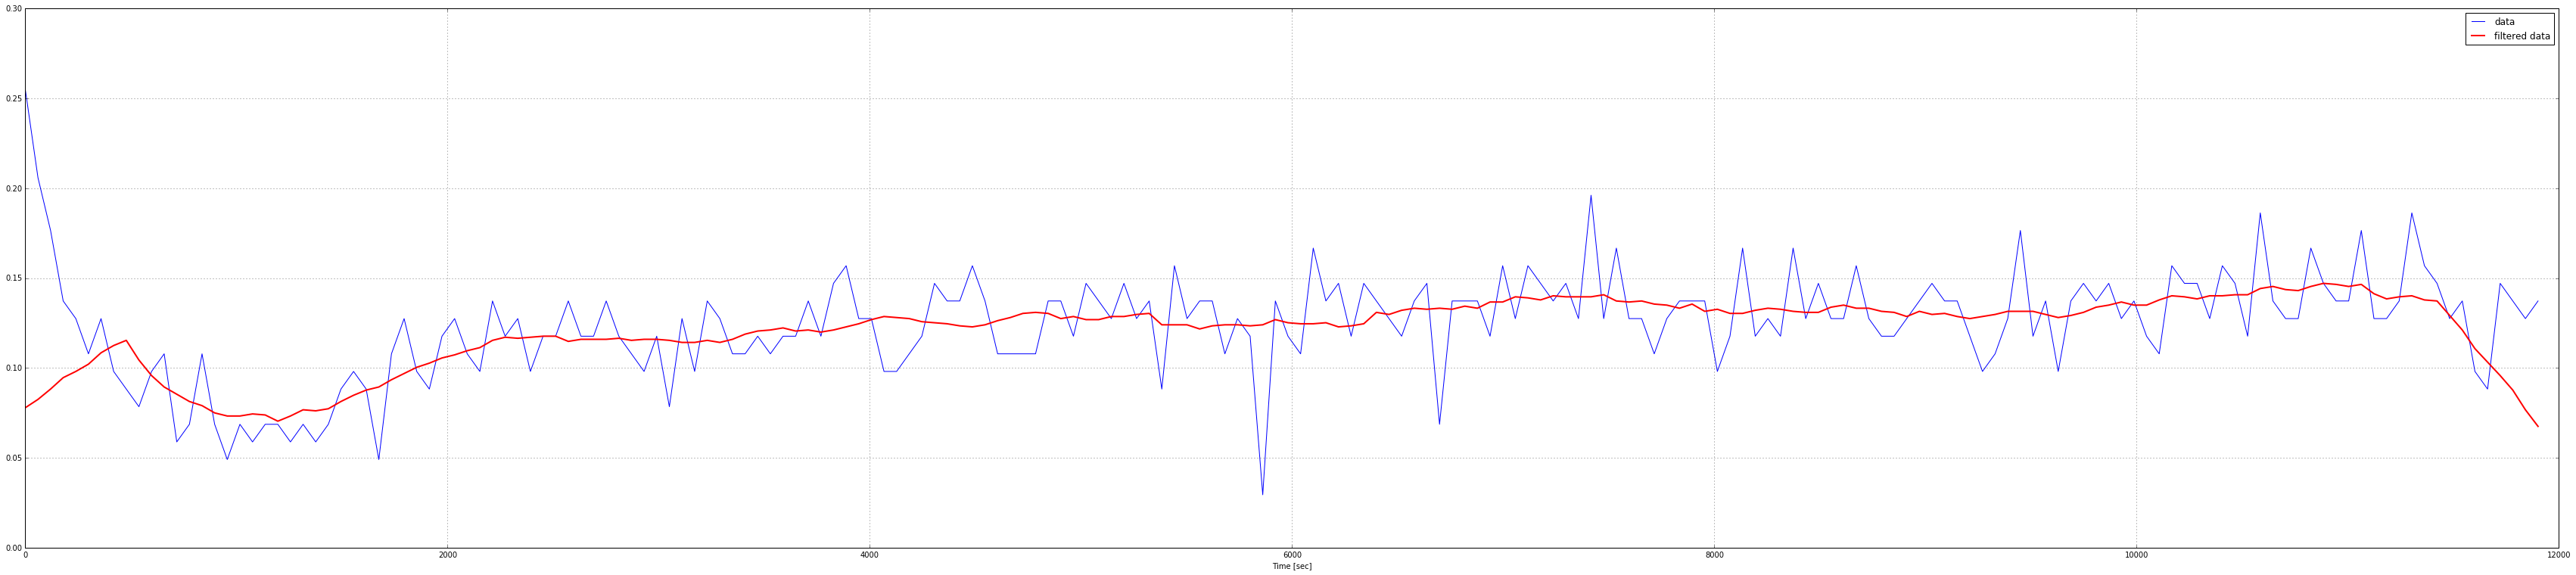

In [21]:
plt.subplot(2, 1, 2)
plt.plot(t, x, 'b-', label='data')
plt.plot(t, x_avg, 'r-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()
plt.subplots_adjust(hspace=0.35)
plt.figure(figsize=(100, 50), dpi= 80, facecolor='w', edgecolor='k')
fig_size = [20,10]
plt.rcParams['figure.figsize'] = fig_size
plt.gcf().set_size_inches(*fig_size)
plt.show()

### Wavelet de-noising

Wavelets can be used to decompose a signal into a series of coefficients. The first coefficients represent the lowest frequencies, and the last coefficients represent the highest frequencies. By removing the higher frequency coefficients and then reconstructing the signal with the truncated coefficients, we can smooth the signal without smoothing over all of the interesting peaks the way we would with a moving average.

All wavelet transforms may be considered forms of time-frequency representation for continuous-time (analog) signals and so are related to harmonic analysis. Almost all practically useful discrete wavelet transforms use discrete-time filterbanks. These filter banks are called the wavelet and scaling coefficients in wavelets nomenclature. These filterbanks may contain either finite impulse response (FIR) or infinite impulse response (IIR) filters. 

The main difference between Fourier and wavelets in general is that wavelets are localized in both time and frequency whereas the standard Fourier transform is only localized in frequency.

There are different ways of defining a wavelet:
 - Scaling Filter: An orthogonal wavelet is entirely defined by the scaling filter – a low-pass finite impulse response (FIR) filter of length 2N and sum 1. 
 
 - Scaling Function: Wavelets are defined by the wavelet function ψ(t) (i.e. the mother wavelet) and scaling function φ(t) (also called father wavelet) in the time domain. The wavelet function is in effect a band-pass filter and scaling it for each level halves its bandwidth. 
 
 - Wavelet Function: The wavelet only has a time domain representation as the wavelet function ψ(t).Mexican hat wavelets can be defined by a wavelet function. 
 

Python wavelet families

In [22]:
pywt.wavelist(kind='discrete')

['bior1.1',
 'bior1.3',
 'bior1.5',
 'bior2.2',
 'bior2.4',
 'bior2.6',
 'bior2.8',
 'bior3.1',
 'bior3.3',
 'bior3.5',
 'bior3.7',
 'bior3.9',
 'bior4.4',
 'bior5.5',
 'bior6.8',
 'coif1',
 'coif2',
 'coif3',
 'coif4',
 'coif5',
 'coif6',
 'coif7',
 'coif8',
 'coif9',
 'coif10',
 'coif11',
 'coif12',
 'coif13',
 'coif14',
 'coif15',
 'coif16',
 'coif17',
 'db1',
 'db2',
 'db3',
 'db4',
 'db5',
 'db6',
 'db7',
 'db8',
 'db9',
 'db10',
 'db11',
 'db12',
 'db13',
 'db14',
 'db15',
 'db16',
 'db17',
 'db18',
 'db19',
 'db20',
 'db21',
 'db22',
 'db23',
 'db24',
 'db25',
 'db26',
 'db27',
 'db28',
 'db29',
 'db30',
 'db31',
 'db32',
 'db33',
 'db34',
 'db35',
 'db36',
 'db37',
 'db38',
 'dmey',
 'haar',
 'rbio1.1',
 'rbio1.3',
 'rbio1.5',
 'rbio2.2',
 'rbio2.4',
 'rbio2.6',
 'rbio2.8',
 'rbio3.1',
 'rbio3.3',
 'rbio3.5',
 'rbio3.7',
 'rbio3.9',
 'rbio4.4',
 'rbio5.5',
 'rbio6.8',
 'sym2',
 'sym3',
 'sym4',
 'sym5',
 'sym6',
 'sym7',
 'sym8',
 'sym9',
 'sym10',
 'sym11',
 'sym12',
 'sym13',

In [23]:
# Show last wavelet of each family
for family in pywt.families():
    list = pywt.wavelist(family = family,kind = 'discrete')
    print list[len(list)-1]

haar
db38
sym20
coif17
bior6.8
rbio6.8
dmey
gaus8
mexh
morl
cgau8
shan
fbsp
cmor


The level argument determines the level of smoothing, but it depends on the length of the signal that you are smoothing, so start with 1, and then move up to 2, etc, until you get an error.

/usr/local/lib/python2.7/dist-packages/pywt/_multilevel.py:45: UserWarning: Level value of 8 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))
/usr/local/lib/python2.7/dist-packages/pywt/_multilevel.py:45: UserWarning: Level value of 8 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


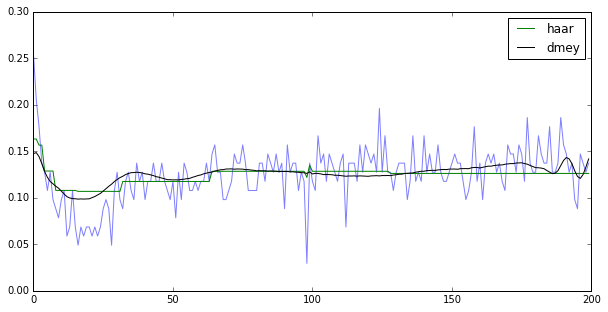

In [27]:
# Single wavelet
from random import uniform

plt.plot( x, color="b", alpha=0.5 )

waves = ['haar', 'db38', 'sym20', 'coif17', 'bior6.8', 
         'dmey']
colors = ['g','r','c','m','y','k']

for i in (0,len(waves)-1):
    wave = waves[i]
    # Calculate wavelet coefficients
    level = 1
    x_coeffs = pywt.wavedec(x, wave, level = 8, mode = 'per')

    # Calculate a threshold
    sigma = mad(x_coeffs[-level])
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    x_coeffs[1:] = ( pywt.threshold( i, value=uthresh, mode="soft" ) for i in x_coeffs[1:] )

    # reconstruct the signal using the thresholded coefficients
    w = pywt.waverec( x_coeffs, wave, mode="per" )
    
    plt.plot( w, color=colors[i], label = wave)
  
fig_size = [10,5]
plt.rcParams['figure.figsize'] = fig_size
plt.gcf().set_size_inches(*fig_size)

plt.xlim(0,200)
plt.legend()
plt.show()

0.0195504146281
0.0636414336782


/usr/local/lib/python2.7/dist-packages/pywt/_multilevel.py:45: UserWarning: Level value of 6 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


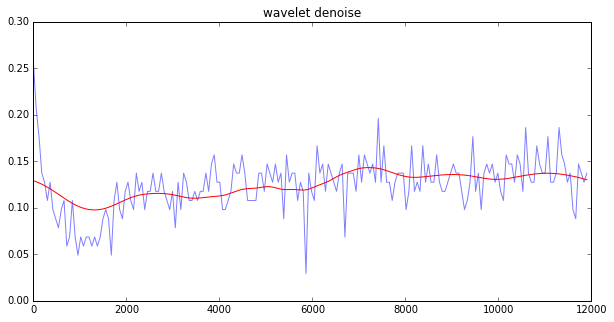

In [67]:
# Single wavelet

# Calculate wavelet coefficients
wave = 'db38'
level = 1
x_coeffs = pywt.wavedec(x, wave, level = 6, mode = 'per')

# Calculate a threshold
sigma = mad(x_coeffs[-level])
print sigma
# changing this threshold also changes the behavior,
uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
print uthresh
x_coeffs[1:] = ( pywt.threshold( i, value=uthresh, mode="soft" ) for i in x_coeffs[1:] )

# reconstruct the signal using the thresholded coefficients
w = pywt.waverec( x_coeffs, wave, mode="per" )
f, ax = plt.subplots()
plt.plot( t, x, color="b", alpha=0.5 )
plt.plot( t, w, color="r" )
fig_size = [10,5]
plt.rcParams['figure.figsize'] = fig_size
plt.gcf().set_size_inches(*fig_size)
ax.set_title('wavelet denoise')

Let's see the average of noisy and filtered measurements

In [29]:
x_avg = np.average(x)
x_favg = np.average(w)
x_avg, x_favg

(0.12434832199999998, 0.1240819581929689)

Now let's substract the average to both measurements, compare, and check if now the measurement is around 0 (should be)

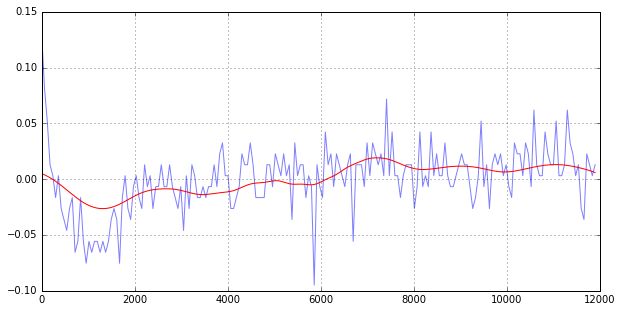

In [30]:
# Substract
xavg = x[:]-x_avg
xfavg = w[:]-x_favg

plt.plot( t, xavg, color="b", alpha=0.5 )
plt.plot( t, xfavg, color="r" )
plt.grid()
fig_size = [10,5]
plt.rcParams['figure.figsize'] = fig_size
plt.gcf().set_size_inches(*fig_size)
ax.set_title('wavelet denoise')

Let's see the new average

In [31]:
print np.average(xfavg)

-1.11022302463e-18


# Working with y magnitude

In [32]:
useful_names = ['linear_acceleration.y_x','linear_acceleration.y_y']
y_data = pd.read_csv('imu_linear.csv', header = None,names = names, usecols = useful_names)

In [33]:
y_data = pd.read_csv('imu_linear.csv', header = None,names = names, usecols = ['linear_acceleration.y_y'])

y_data_array = y_data.values
y_data_array = np.delete(y_data_array,0)

#x_time_array.delete('linear_acceleration.x_x')
y = []
for i in y_data_array:
    y.append(float(i))

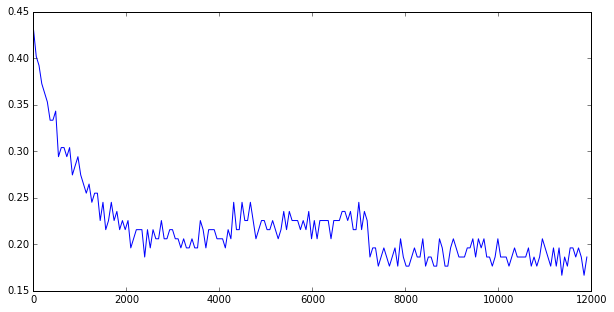

In [34]:
plt.plot(t,y)

In [35]:
allan_y = allantools.Dataset(data=y)
y_mdev = allan_y.compute("mdev")

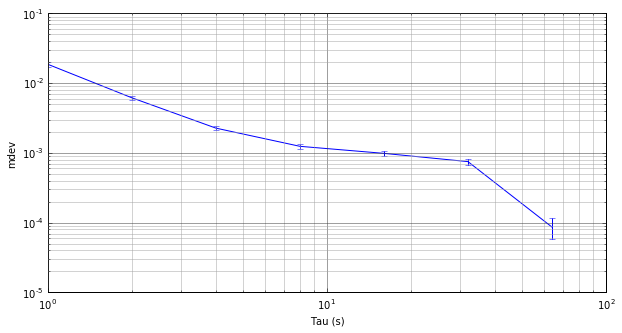

In [36]:
allan_y_plot = allantools.Plot()
allan_y_plot.plot(allan_y, errorbars=True, grid=True)
# You can override defaults before "show" if needed
allan_y_plot.ax.set_xlabel("Tau (s)")
allan_y_plot.show()

In [37]:
y_tau  = y_mdev['taus']
y_avar = y_mdev['stat']
y_params, av_pred = allan_variance.params_from_avar(y_tau,y_avar,output_type='dict')
y_params

OrderedDict([('quantization', 0.0609926322099218),
             ('white', 0.084993964463211516),
             ('flicker', 0.0),
             ('walk', 0.0),
             ('ramp', 0.0)])

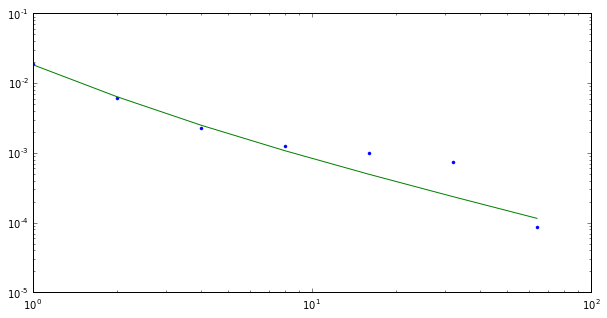

In [38]:
plt.loglog(y_tau, y_avar, '.')
plt.loglog(y_tau, av_pred)

## Filtering

### Low-pass filter

In [39]:
# Filter the data, and plot both the original and filtered signals.
y_lpf = lowpass.butter_lowpass_filter(y, cutoff, fs, order)

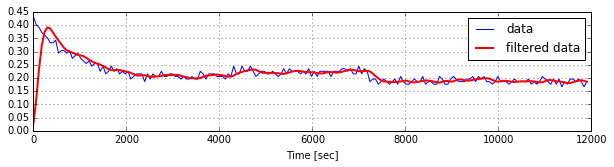

In [40]:
plt.subplot(2, 1, 2)
plt.plot(t, y, 'b-', label='data')
plt.plot(t, y_lpf, 'r-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.figure(figsize=(100, 50), dpi= 80, facecolor='w', edgecolor='k')
fig_size = [20,10]
plt.rcParams['figure.figsize'] = fig_size
plt.gcf().set_size_inches(*fig_size)
plt.show()

### Moving Average filter

In [41]:
# Select window size for average filter of 17
# which is the number of measurements read in 1s
window_size = 17
y_avg = np.zeros(len(y))
avg_mask = np.ones(window_size)/window_size
y_avg = np.convolve(y, avg_mask, 'same')

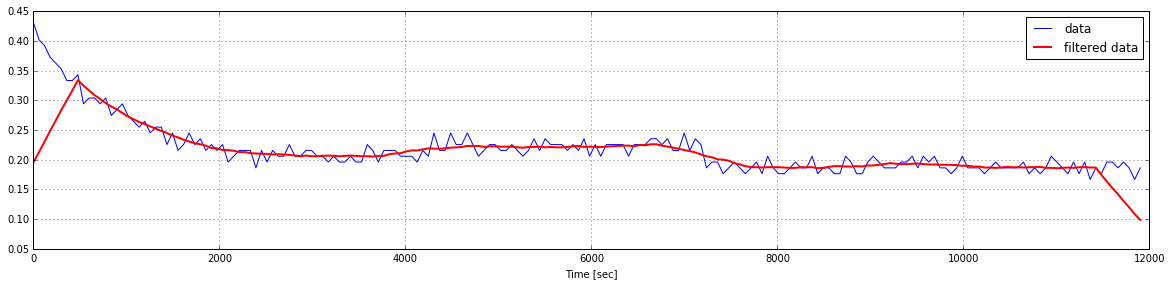

In [42]:
plt.subplot(2, 1, 2)
plt.plot(t, y, 'b-', label='data')
plt.plot(t, y_avg, 'r-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.figure(figsize=(100, 50), dpi= 80, facecolor='w', edgecolor='k')
fig_size = [20,10]
plt.rcParams['figure.figsize'] = fig_size
plt.gcf().set_size_inches(*fig_size)
plt.show()

### Wavelet de-noising

0.0132955547872
0.0432803183103


/usr/local/lib/python2.7/dist-packages/pywt/_multilevel.py:45: UserWarning: Level value of 6 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


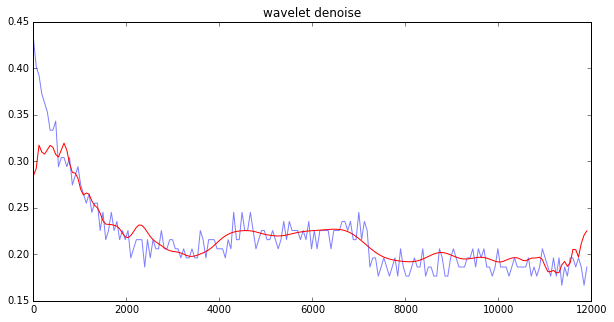

In [43]:
# Single wavelet

# Calculate wavelet coefficients
wave = 'db38'
level = 1
y_coeffs = pywt.wavedec(y, wave, level = 6, mode = 'per')

# Calculate a threshold
sigma = mad(y_coeffs[-level])
print sigma
# changing this threshold also changes the behavior,
uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
print uthresh
y_coeffs[1:] = ( pywt.threshold( i, value=uthresh, mode="soft" ) for i in y_coeffs[1:] )

# reconstruct the signal using the thresholded coefficients
w = pywt.waverec( y_coeffs, wave, mode="per" )
f, ax = plt.subplots()
plt.plot( t,y, color="b", alpha=0.5 )
plt.plot( t,w, color="r" )
fig_size = [10,5]
plt.rcParams['figure.figsize'] = fig_size
plt.gcf().set_size_inches(*fig_size)
ax.set_title('wavelet denoise')

In [44]:
y_avg = np.average(y)
y_favg = np.average(w)
y_avg, y_favg

(0.21756053024999999, 0.21859934785889576)

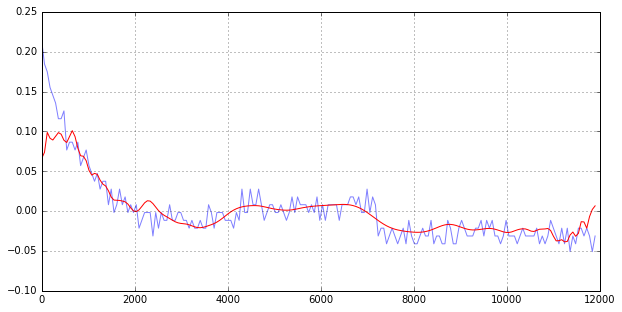

In [45]:
# Substract
yavg = y[:]-y_avg
yfavg = w[:]-y_favg

plt.plot( t, yavg, color="b", alpha=0.5 )
plt.plot( t, yfavg, color="r" )
plt.grid()
fig_size = [10,5]
plt.rcParams['figure.figsize'] = fig_size
plt.gcf().set_size_inches(*fig_size)
ax.set_title('wavelet denoise')

In [46]:
print np.average(yfavg)

-2.33146835171e-17


## Working with z magnitude

In [47]:
useful_names = ['linear_acceleration.z_x','linear_acceleration.z_y']
z_data = pd.read_csv('imu_linear.csv', header = None,names = names, usecols = useful_names)

In [48]:
z_data = pd.read_csv('imu_linear.csv', header = None,names = names, usecols = ['linear_acceleration.z_y'])

z_data_array = z_data.values
z_data_array = np.delete(z_data_array,0)

z = []
for i in z_data_array:
    z.append(float(i))

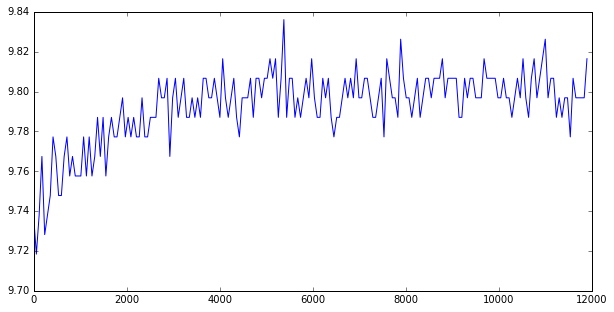

In [49]:
plt.plot(t,z)

In [50]:
allan_z = allantools.Dataset(data=z)
z_mdev = allan_z.compute("mdev")

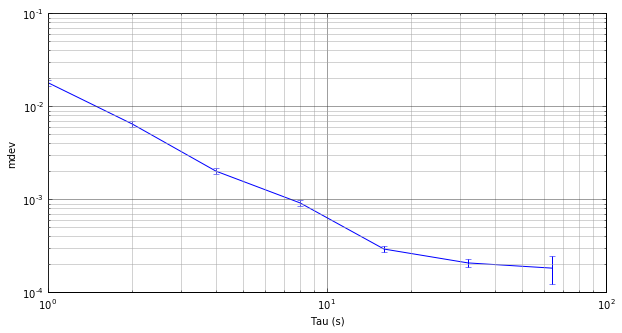

In [51]:
allan_z_plot = allantools.Plot()
allan_z_plot.plot(allan_z, errorbars=True, grid=True)
# You can override defaults before "show" if needed
allan_z_plot.ax.set_xlabel("Tau (s)")
allan_z_plot.show()

In [52]:
z_tau  = z_mdev['taus']
z_avar = z_mdev['stat']
z_params, av_pred = allan_variance.params_from_avar(z_tau,z_avar,output_type='dict')
z_params

OrderedDict([('quantization', 0.071479865669497086),
             ('white', 0.0644998083260023),
             ('flicker', 0.0),
             ('walk', 0.0018955847822821291),
             ('ramp', 0.00013826772268494482)])

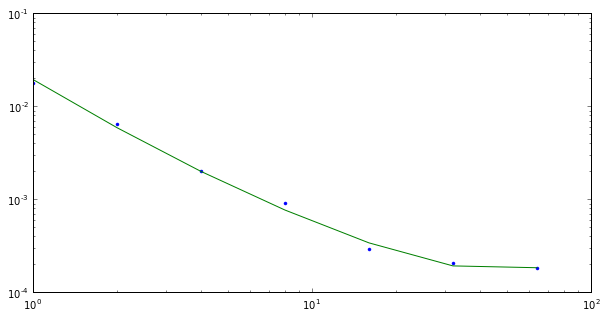

In [53]:
plt.loglog(z_tau, z_avar, '.')
plt.loglog(z_tau, av_pred)

## Filtering

### Low-pass filter

In [54]:
# Filter the data, and plot both the original and filtered signals.
z_lpf = lowpass.butter_lowpass_filter(z, cutoff, fs, order)

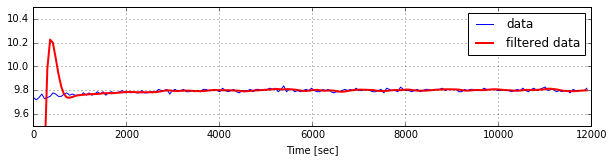

In [55]:
plt.subplot(2, 1, 2)
plt.plot(t, z, 'b-', label='data')
plt.plot(t, z_lpf, 'r-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()
plt.ylim(9.5,10.5)
plt.subplots_adjust(hspace=0.35)
plt.figure(figsize=(100, 50), dpi= 80, facecolor='w', edgecolor='k')
fig_size = [20,11]
plt.rcParams['figure.figsize'] = fig_size
plt.gcf().set_size_inches(*fig_size)

### Moving Average Filter

In [56]:
# Select window size for average filter of 17
# which is the number of measurements read in 1s
window_size = 17
y_avg = np.zeros(len(z))
avg_mask = np.ones(window_size)/window_size
z_avg = np.convolve(z, avg_mask, 'same')

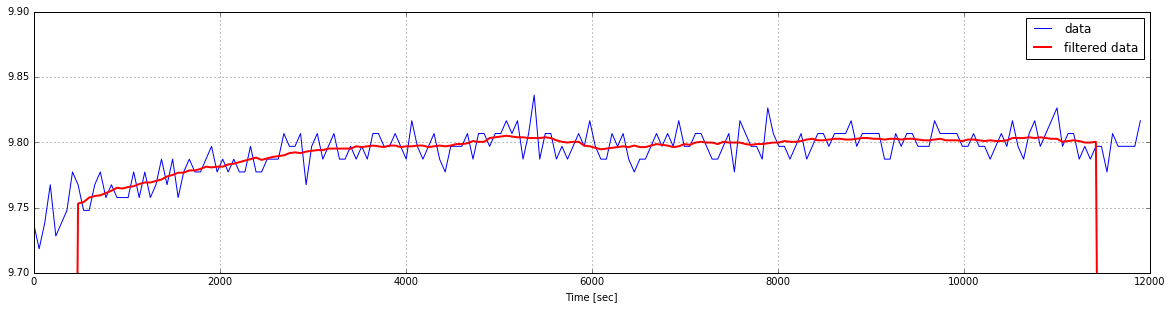

In [57]:
plt.subplot(2, 1, 2)
plt.plot(t, z, 'b-', label='data')
plt.plot(t, z_avg, 'r-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()
plt.ylim(9.7,9.9)
plt.subplots_adjust(hspace=0.35)
plt.figure(figsize=(100, 50), dpi= 80, facecolor='w', edgecolor='k')
fig_size = [10,10]
plt.rcParams['figure.figsize'] = fig_size
plt.gcf().set_size_inches(*fig_size)
plt.show()

### Wavelet de-noising

0.0104060756842
0.0338743493733


/usr/local/lib/python2.7/dist-packages/pywt/_multilevel.py:45: UserWarning: Level value of 6 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


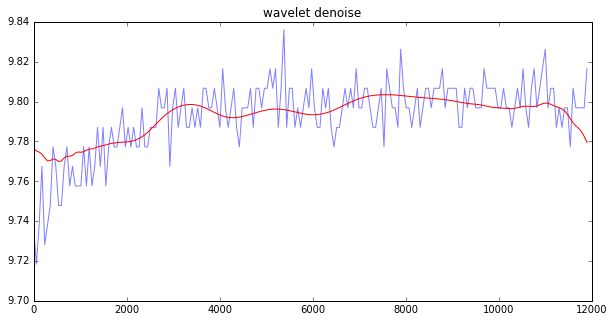

In [58]:
# Single wavelet

# Calculate wavelet coefficients
wave = 'db38'
level = 1
z_coeffs = pywt.wavedec(z, wave, level = 6, mode = 'per')

# Calculate a threshold
sigma = mad(z_coeffs[-level])
print sigma
# changing this threshold also changes the behavior,
uthresh = sigma * np.sqrt( 2*np.log( len( z ) ) )
print uthresh
z_coeffs[1:] = ( pywt.threshold( i, value=uthresh, mode="soft" ) for i in z_coeffs[1:] )

# reconstruct the signal using the thresholded coefficients
w = pywt.waverec( z_coeffs, wave, mode="per" )
f, ax = plt.subplots()
plt.plot( t,z, color="b", alpha=0.5 )
plt.plot( t,w, color="r" )
fig_size = [10,5]
plt.rcParams['figure.figsize'] = fig_size
plt.gcf().set_size_inches(*fig_size)
ax.set_title('wavelet denoise')

In [59]:
z_avg = np.average(z)
z_favg = np.average(w)
z_avg, z_favg

(9.7927245570000014, 9.7925394554607088)

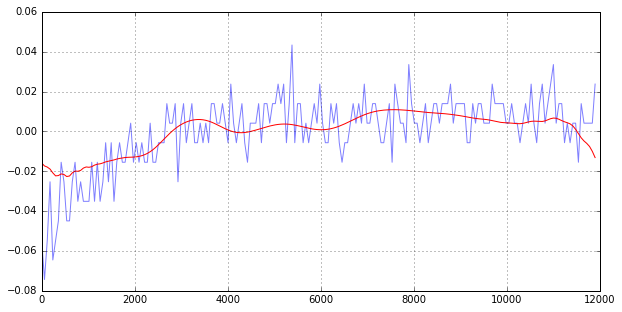

In [60]:
# Substract
zavg = z[:]-z_avg
zfavg = w[:]-z_favg

plt.plot( t, zavg, color="b", alpha=0.5 )
plt.plot( t, zfavg, color="r" )
plt.grid()
fig_size = [10,5]
plt.rcParams['figure.figsize'] = fig_size
plt.gcf().set_size_inches(*fig_size)
ax.set_title('wavelet denoise')

In [61]:
print np.average(zfavg)

-1.95399252334e-16
